#### Detect model from Yu, et al
Implementation of the detection model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing)

First run - following paper as closely as possible. Data was resized to 224x224 and median filtered 7x7. None type was subsampled to keep only 30,000 random samples.

In [1]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, optimizers

import os
import numpy as np
import pandas as pd
import pickle5 as pickle

import helpers as helper
import seaborn as sns
from sklearn.metrics import confusion_matrix

import time

In [2]:
# specify variables for model
path = '../../data'
filename = 'WM-clean-id224filter7'
option = '-detund' # -clsaug, -detund
map_column = 'filterMap7'
label_column = 'detectLabels'
filetype = 'zip' # zip, pkl

model_id = 'yudetect'
result_path = '../results'
note = '' # -optional

In [6]:
# load train, dev, and test sets
if filetype == 'pkl':
    # open pkl files
    with open(f'{path}/{filename}-train{option}.pkl', "rb") as fh:
        train = pickle.load(fh)
    with open(f'{path}/{filename}-dev.pkl', "rb") as fh:
        dev = pickle.load(fh)
    with open(f'{path}/{filename}-test.pkl', "rb") as fh:
        test = pickle.load(fh)

elif filetype == 'zip':
    train = helper.load(f'{path}/{filename}-train{option}.zip')
    dev = helper.load(f'{path}/{filename}-dev.zip')
    test = helper.load(f'{path}/{filename}-test.zip')

print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

Train: 47863
Dev: 25942
Test: 25943


#### Quick EDA

In [7]:
# baseline accuracy of test set
nones = len(test[test.failureType == 'none'])
total = len(test)
print(f"Baseline accuracy: {nones/total*100:.2f}%")

Baseline accuracy: 85.24%


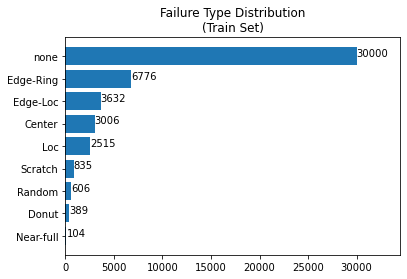

In [8]:
# train failure type distribution
helper.defect_distribution(train, note='Train Set')

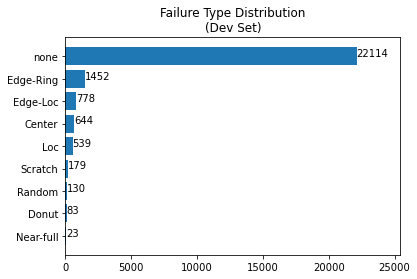

In [9]:
# dev failure type distribution
helper.defect_distribution(dev, note='Dev Set')

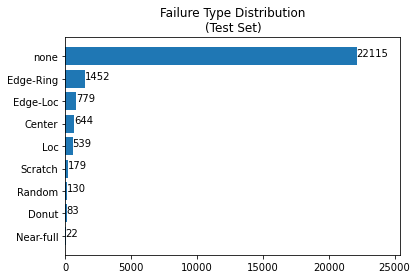

In [10]:
# test failure type distribution
helper.defect_distribution(test, note='Test Set')

#### Data set-up

In [11]:
# prepare inputs
x_train = np.stack(train[map_column])
x_val = np.stack(dev[map_column])
x_test = np.stack(test[map_column])

# sanity check
# expected: (#rows, xdim, ydim)
x_train.shape

(47863, 224, 224)

In [12]:
# expand tensor and create dummy dimension at axis 3
# images in greyscale, so no channel dimension
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_train.shape

TensorShape([47863, 224, 224, 1])

In [13]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
y_train = np.asarray(train[label_column]).astype('int64')
y_val = np.asarray(dev[label_column]).astype('int64')
y_test = np.asarray(test[label_column]).astype('int64')

In [14]:
# sanity check
type(y_train[0])

numpy.int64

#### Model

In [15]:
# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='sigmoid'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [16]:
# set model optimizer and metrics
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [17]:
# run model
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
748/748 [==============================] - 653s 871ms/step - loss: 0.3557 - accuracy: 0.8524 - val_loss: 0.1828 - val_accuracy: 0.9438
Epoch 2/10
748/748 [==============================] - 626s 836ms/step - loss: 0.1858 - accuracy: 0.9286 - val_loss: 0.0840 - val_accuracy: 0.9720
Epoch 3/10
748/748 [==============================] - 622s 832ms/step - loss: 0.1139 - accuracy: 0.9575 - val_loss: 0.0714 - val_accuracy: 0.9757
Epoch 4/10
748/748 [==============================] - 615s 822ms/step - loss: 0.0912 - accuracy: 0.9653 - val_loss: 0.1791 - val_accuracy: 0.9300
Epoch 5/10
748/748 [==============================] - 620s 829ms/step - loss: 0.0784 - accuracy: 0.9704 - val_loss: 0.0602 - val_accuracy: 0.9780
Epoch 6/10
748/748 [==============================] - 628s 839ms/step - loss: 0.0674 - accuracy: 0.9747 - val_loss: 0.0655 - val_accuracy: 0.9764
Epoch 7/10
748/748 [==============================] - 673s 900ms/step - loss: 0.0544 - accuracy: 0.9798 - val_loss: 0.0884 -

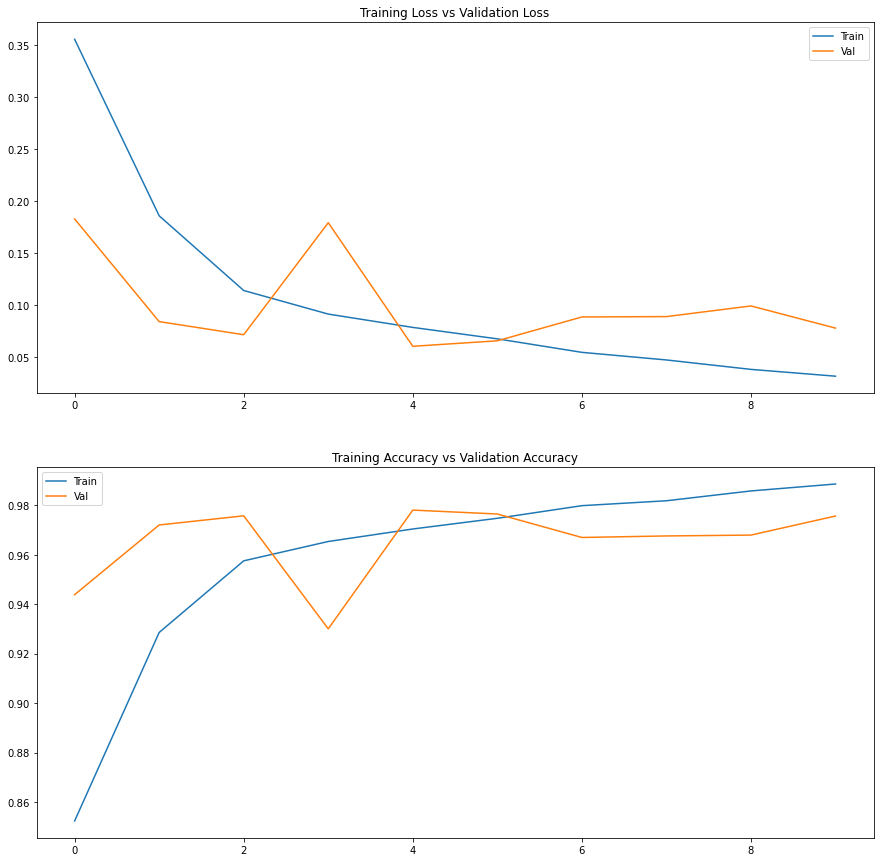

In [18]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [19]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {} seconds".format(time.time() - start))
print(results)

811/811 [==============================] - 112s 137ms/step - loss: 0.0694 - accuracy: 0.9778
Wall time: 111.67420482635498 seconds
[0.06937910616397858, 0.9777589440345764]


In [20]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print("Wall time: {} seconds".format(time.time() - start))

# if googlenet
# pred = model.predict(x_test)
# y_pred = np.argmax(pred[0], axis=1)

Wall time: 108.57050609588623 seconds


In [32]:
# save results, history, and predictions
with open(f'../../results/{model_id}-{filename}{option}{note}.pkl', "wb") as f:
    pickle.dump(y_pred, f)

##### Plotting confusion matrix after run

In [3]:
# load train, dev, and test sets
test = helper.load(f'{path}/{filename}-test.zip')
print(f"Test: {len(test)}")

y_test = np.asarray(test[label_column]).astype('int64')

# baseline accuracy of test set
nones = len(test[test.failureType == 'none'])
total = len(test)
print(f"Baseline accuracy: {nones/total*100:.2f}%")

Test: 25943
Baseline accuracy: 85.24%


In [4]:
# load results
with open(f'../../results/{model_id}-{filename}{option}{note}.pkl', "rb") as fh:
    y_pred = pickle.load(fh)
len(y_pred)

25943

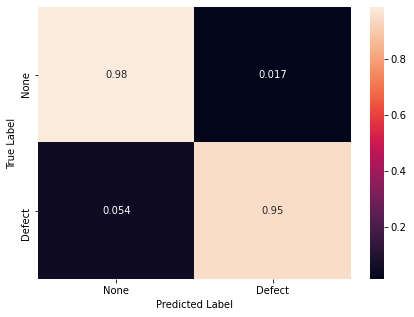

In [5]:
helper.plot_confusion_matrix(y_test, y_pred, mode='detect', normalize=True)

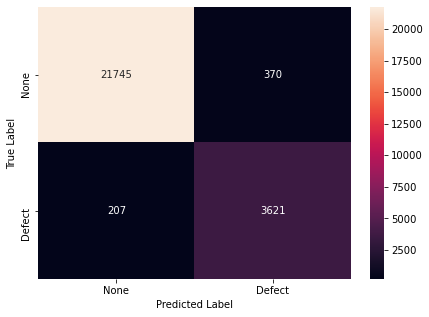

In [6]:
helper.plot_confusion_matrix(y_test, y_pred, mode='detect', normalize=False)